In [1]:
include("dependencies.jl")
include("functions/brute_force_new.jl")
include("functions/boundary_evolution.jl")
push!(LOAD_PATH, "functions/")
using BP, Ising2D
using Plots
using Colors  # for color conversion

In [25]:
function loop_corrected_free_energy(L,β;h=0)
    N = 2 * L^2
    tensors = Ising2D.get_ising_tn(L, β; h=h)
    BPadj_mat, BPedges, BPlinks = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, BPedges, BPlinks;random_part=.1) 
    messages = BP.message_passing(tensors, messages, BPedges, BPadj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
    Z_l = BP.get_fixed_point_list(tensors, messages, BPadj_mat)
    # Use log-sum trick for numerical stability: log(prod(Z_l)) = sum(log.(Z_l))
    log_Z_sum = sum(log.(real.(Z_l)))    
    # free_energy = - log_Z_sum / (2 * L^2)
    T_normalized = BP.normalize_tensors(tensors,Z_l)
    correction_l = []

    Z = 1.
    push!(correction_l, - log_Z_sum /N - log(Z)/N)
    Z += ZCorrection4th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, - log_Z_sum /N - log(Z)/N)
    Z += ZCorrection6th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, - log_Z_sum /N - log(Z)/N)
    Z += ZCorrection7th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, - log_Z_sum /N - log(Z)/N)
    return real(correction_l)
end 


function log_loop_corrected_free_energy(L,β;h=0)
    N = 2 * L^2
    tensors = Ising2D.get_ising_tn(L, β; h=h)
    BPadj_mat, BPedges, BPlinks = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, BPedges, BPlinks;random_part=.1) 
    messages = BP.message_passing(tensors, messages, BPedges, BPadj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
    Z_l = BP.get_fixed_point_list(tensors, messages, BPadj_mat)
    # Use log-sum trick for numerical stability: log(prod(Z_l)) = sum(log.(Z_l))
    log_Z_sum = sum(log.(real.(Z_l)))    
    # free_energy = - log_Z_sum / (2 * L^2)
    T_normalized = BP.normalize_tensors(tensors,Z_l)

    log_correction_l = []
    logZ = 0.0  # Initialize as Float64 instead of Int
    push!(log_correction_l, -(logZ/N + log_Z_sum/N))
    
    # Remove scalar() calls since corrections are already scalar values
    correction_4th = real(logZCorrection4th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat))
    logZ += correction_4th
    push!(log_correction_l, -(logZ/N + log_Z_sum/N))
    
    correction_6th = real(logZCorrection6th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat))
    logZ += correction_6th
    push!(log_correction_l, -(logZ/N + log_Z_sum/N))
    
    correction_7th = real(logZCorrection7th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat))
    logZ += correction_7th
    push!(log_correction_l, -(logZ/N + log_Z_sum/N))
    return real(log_correction_l)
end 

log_loop_corrected_free_energy (generic function with 1 method)

Computing free energy for L=16... 100%|██████████████████| Time: 0:00:31
Computing free energy for L=16... 100%|██████████████████| Time: 0:00:31


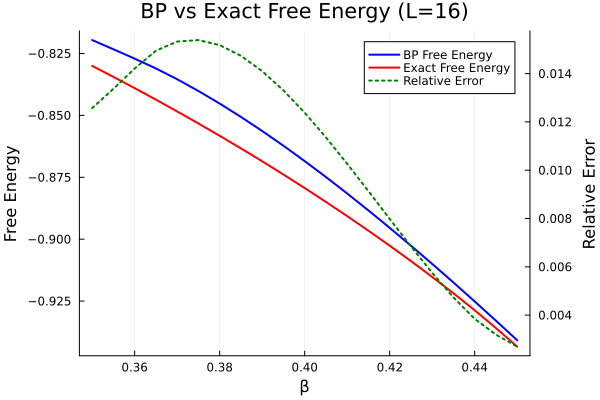

In [36]:
L = 16  # Define L here
β_arr = collect(0.35:0.005:0.45)
h = 0.0  # External magnetic field (assuming zero if not specified)
free_energy_arr = Float64[]
exact_free_energy = Float64[]
 
# Progress meter to track computation
@showprogress "Computing free energy for L=$L..." for β in β_arr
    tensors = Ising2D.get_ising_tn(L, β; h=h)
    BPadj_mat, BPedges, BPlinks = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, BPedges, BPlinks;random_part=.1) 
    messages = BP.message_passing(tensors, messages, BPedges, BPadj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
    Z_l = BP.get_fixed_point_list(tensors, messages, BPadj_mat)
    # Use log-sum trick for numerical stability: log(prod(Z_l)) = sum(log.(Z_l))
    log_Z_sum = sum(log.(real.(Z_l)))    
    free_energy = - log_Z_sum / (2 * L^2)
    push!(free_energy_arr, free_energy)
    push!(exact_free_energy, Ising2D.free_energy(β))
end

# Calculate relative error
relative_error = abs.(free_energy_arr .- exact_free_energy) ./ abs.(exact_free_energy)

# Create plot with two y-axes
p1 = plot(β_arr, free_energy_arr, 
          linewidth=2, 
          label="BP Free Energy", 
          color=:blue,
          xlabel="β", 
          ylabel="Free Energy",
          title="BP vs Exact Free Energy (L=$L)",
          legend=:topright)

plot!(p1, β_arr, exact_free_energy, 
      linewidth=2, 
      label="Exact Free Energy", 
      color=:red)

# Create second y-axis for relative error
p2 = twinx(p1)
plot!(p2, β_arr, relative_error, 
      linewidth=2, 
      color=:green, 
      linestyle=:dot,
      label="Relative Error",
      ylabel="Relative Error",
      legend=false)  # Disable legend for second axis

# Manually create combined legend
plot!(p1, [], [], 
      linewidth=2, 
      color=:green, 
      linestyle=:dot,
      label="Relative Error")

# Display the plot
display(p1)

4
8
12
12


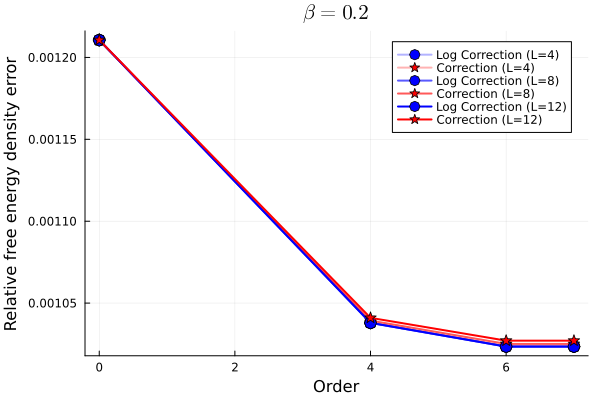

In [31]:
##noisy init
L_arr = [4, 8, 12]
β = 0.2
orders = [0, 4, 6, 7]
colors = Dict("log" => colorant"blue", "corr" => colorant"red")

plt = plot(title = L"\beta = %$(β)",
     xlabel = "Order",
     ylabel = "Relative free energy density error")

for (i, L) in enumerate(L_arr)
    println(L)  
    alpha = 0.3 + 0.7 * (i - 1) / (length(L_arr) - 1)

    exact_fe = Ising2D.free_energy(β)
    y1 = (log_loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    y2 = (loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    c1 = RGBA(colors["log"].r, colors["log"].g, colors["log"].b, alpha)
    c2 = RGBA(colors["corr"].r, colors["corr"].g, colors["corr"].b, alpha)

    plot!(orders, y1;
          label = "Log Correction (L=$L)",
          color = c1,
          linewidth = 2,
          marker = :o,
          markersize = 6)

    plot!(orders, y2;
          label = "Correction (L=$L)",
          color = c2,
          linewidth = 2,
          marker = :s,
          markersize = 6)
end

# annotate!(5, 0.5 * maximum(y1), text(" ", :left, 12))
plt

4
8
12
8
12


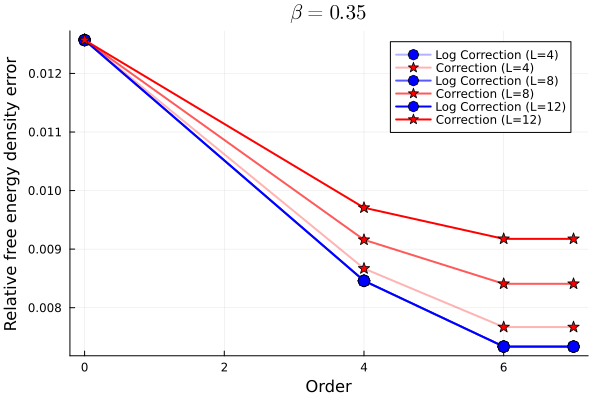

In [32]:
##noisy init
L_arr = [4, 8, 12]
β = 0.35
orders = [0, 4, 6, 7]
colors = Dict("log" => colorant"blue", "corr" => colorant"red")

plt = plot(title = L"\beta = %$(β)",
     xlabel = "Order",
     ylabel = "Relative free energy density error")

for (i, L) in enumerate(L_arr)
    println(L)  
    alpha = 0.3 + 0.7 * (i - 1) / (length(L_arr) - 1)

    exact_fe = Ising2D.free_energy(β)
    y1 = (log_loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    y2 = (loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    c1 = RGBA(colors["log"].r, colors["log"].g, colors["log"].b, alpha)
    c2 = RGBA(colors["corr"].r, colors["corr"].g, colors["corr"].b, alpha)

    plot!(orders, y1;
          label = "Log Correction (L=$L)",
          color = c1,
          linewidth = 2,
          marker = :o,
          markersize = 6)

    plot!(orders, y2;
          label = "Correction (L=$L)",
          color = c2,
          linewidth = 2,
          marker = :s,
          markersize = 6)
end

# annotate!(5, 0.5 * maximum(y1), text(" ", :left, 12))
plt

4
8
12
8
12


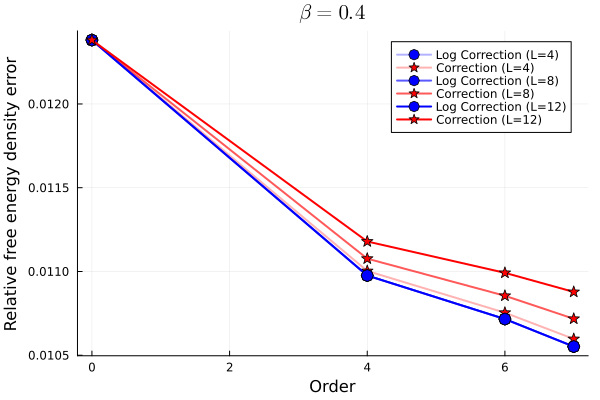

In [33]:
##noisy init
L_arr = [4, 8, 12]
β = 0.4
orders = [0, 4, 6, 7]
colors = Dict("log" => colorant"blue", "corr" => colorant"red")

plt = plot(title = L"\beta = %$(β)",
     xlabel = "Order",
     ylabel = "Relative free energy density error")

for (i, L) in enumerate(L_arr)
    println(L)  
    alpha = 0.3 + 0.7 * (i - 1) / (length(L_arr) - 1)

    exact_fe = Ising2D.free_energy(β)
    y1 = (log_loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    y2 = (loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    c1 = RGBA(colors["log"].r, colors["log"].g, colors["log"].b, alpha)
    c2 = RGBA(colors["corr"].r, colors["corr"].g, colors["corr"].b, alpha)

    plot!(orders, y1;
          label = "Log Correction (L=$L)",
          color = c1,
          linewidth = 2,
          marker = :o,
          markersize = 6)

    plot!(orders, y2;
          label = "Correction (L=$L)",
          color = c2,
          linewidth = 2,
          marker = :s,
          markersize = 6)
end

# annotate!(5, 0.5 * maximum(y1), text(" ", :left, 12))
plt

4
8
12
8
12


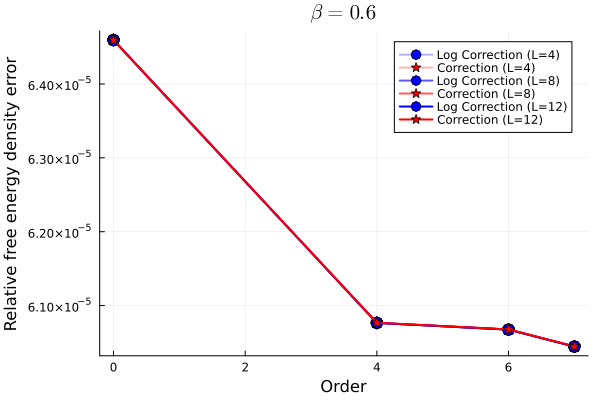

In [34]:
##noisy init
L_arr = [4, 8, 12]
β = 0.6
orders = [0, 4, 6, 7]
colors = Dict("log" => colorant"blue", "corr" => colorant"red")

plt = plot(title = L"\beta = %$(β)",
     xlabel = "Order",
     ylabel = "Relative free energy density error")

for (i, L) in enumerate(L_arr)
    println(L)  
    alpha = 0.3 + 0.7 * (i - 1) / (length(L_arr) - 1)

    exact_fe = Ising2D.free_energy(β)
    y1 = (log_loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    y2 = (loop_corrected_free_energy(L, β) .- exact_fe) ./ abs(exact_fe)
    c1 = RGBA(colors["log"].r, colors["log"].g, colors["log"].b, alpha)
    c2 = RGBA(colors["corr"].r, colors["corr"].g, colors["corr"].b, alpha)

    plot!(orders, y1;
          label = "Log Correction (L=$L)",
          color = c1,
          linewidth = 2,
          marker = :o,
          markersize = 6)

    plot!(orders, y2;
          label = "Correction (L=$L)",
          color = c2,
          linewidth = 2,
          marker = :s,
          markersize = 6)
end

# annotate!(5, 0.5 * maximum(y1), text(" ", :left, 12))
plt

In [ ]:
# scan over β values
βs = range(.01, 1., length=10)

L = 10
N = 2 * L^2
h = 0.0

# array of BP fixed point free energy
bp_fixed_point_free_energy_array = []
# array of loop corrected BP free energy
loop_corrected_free_energy_array = []
log_loop_corrected_free_energy_array = []

# array of bounary evolution free energy
boundary_evolution_free_energy_array = []
# exact free energy
exact_free_energy_array = [Ising2D.free_energy(β) for β in βs]

# time for BP fixed point
bp_fixed_point_time = []

log_loop_correction_time = []
# time for loop corrections
loop_correction_time = []
# time for boundary evolution
boundary_evolution_time = []

for β in βs
    println("Current β: ", β)
    time_start = time()
    bp_fixed_point_free_energy_array = vcat(bp_fixed_point_free_energy_array, BP_fixed_point_free_energy(L,β))
    bp_fixed_point_time = vcat(bp_fixed_point_time, time() - time_start)

    time_start = time()
    loop_corrected_free_energy_array = vcat(loop_corrected_free_energy_array, loop_corrected_free_energy(L,β)[end])
    loop_correction_time = vcat(loop_correction_time, time() - time_start)

    time_start = time()
    log_loop_corrected_free_energy_array = vcat(log_loop_corrected_free_energy_array, log_loop_corrected_free_energy(L,β)[end])
    log_loop_correction_time = vcat(loop_correction_time, time() - time_start)


    time_start = time()
    peps = generate_ising_peps(L, L, β, h)
    partition_function = contract_peps_no_phys(peps; cutoff=1E-8, maxdim=1024)
    boundary_evolution_free_energy_array = vcat(boundary_evolution_free_energy_array, (-log(partition_function)/N)/2)
    boundary_evolution_time = vcat(boundary_evolution_time, time() - time_start)
end

Current β: 0.01
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complete.
Contracting first row into boundary MPS...
Contracting bulk rows...
  Applying MPO from row 2 / 10
  Applying MPO from row 3 / 10
  Applying MPO from row 4 / 10
  Applying MPO from row 5 / 10
  Applying MPO from row 6 / 10
  Applying MPO from row 7 / 10
  Applying MPO from row 8 / 10
  Applying MPO from row 9 / 10
Contracting with final row...
Contraction finished.
Current β: 0.12
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complete.
Contracting first row into boundary MPS...
Contracting bulk rows...
  Applying MPO from row 2 / 10
  Applying MPO from row 3 / 10
  Applying MPO from row 4 / 10
  Applying MPO from row 5 / 10
  Applying MPO from row 6 / 10
  Applying MPO from row 7 / 10
  Applying MPO from row 8 / 10
  Applying MPO from row 9 / 10
Contracting with final row...
Contraction finished.
Current β: 0.23
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complet

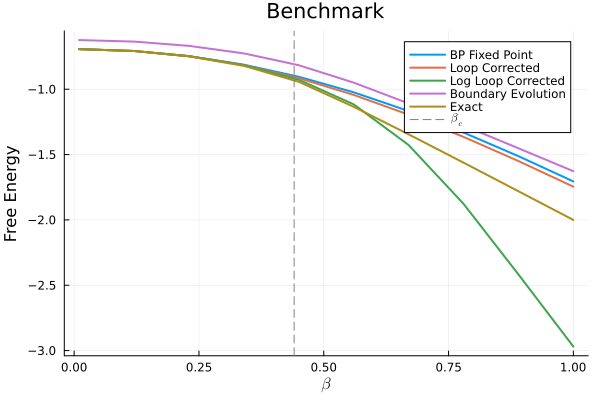

In [62]:
plot(title = "Benchmark", xlabel = L"\beta", ylabel = "Free Energy")

plot!(βs, bp_fixed_point_free_energy_array;
     label = "BP Fixed Point",
     linewidth = 2,
)

plot!(βs, loop_corrected_free_energy_array;
      label = "Loop Corrected",
      linewidth = 2,
)

plot!(βs, log_loop_corrected_free_energy_array;
      label = "Log Loop Corrected",
      linewidth = 2,
)

plot!(βs, boundary_evolution_free_energy_array;
      label = "Boundary Evolution",
      linewidth = 2,
)

plot!(βs, exact_free_energy_array;
      label = "Exact",
      linewidth = 2,
)

vline!([0.4406868], linestyle = :dash, color = :grey, label=L"\beta_c")

In [38]:
log_loop_corrected_free_energy_array

11-element Vector{Any}:
 -0.693247183894657
 -0.7076206004914029
 -0.747213344276731
 -0.8154691964753047
 -0.9156207179122269
 -1.0437490633071518
 -1.1948866177049506
 -1.3649230123161826
 -1.5498034185784806
 -1.7457500563892066
 -2.969403946560505